# Setup

## Packages

In [1]:
# Data analysis
import scanpy as sc
import numpy as np
import pandas as pd

# Pseudo-bulk
import decoupler as dc
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import scipy.stats as stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

### shuffled embedding

In [2]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 150000/adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

### barplots

In [3]:
def get_dataframe_barplot(
    adata,
    groupby,
    color_var: str | None = None,
    *,
    normalize_groupby: bool = True,
    normalize_color_var: bool = True,
    percent: bool = True,
) -> pd.DataFrame:
    df = sc.get.obs_df(
        adata=adata,
        keys=[groupby, color_var],
    )

    df = (
        df.groupby([groupby, color_var], observed=True).size().reset_index(name="count")
    )

    if normalize_groupby:
        df["count"] = df["count"] / (
            df.groupby(groupby, observed=True)["count"].transform("sum")
        )

    if normalize_color_var:
        df["count"] = df["count"] / (
            df.groupby(color_var, observed=True)["count"].transform("sum")
        )

    if percent and (normalize_color_var or normalize_groupby):
        df["count"] *= 100

    return df.pivot(index=groupby, columns=color_var, values="count").fillna(0)

## Dataset

Load dataset

In [ ]:
data_path = "/path/to/data/"

In [ ]:
ko1 = sc.read_h5ad(f"{data_path}TcrdKO1_raw.h5ad")
ko2 = sc.read_h5ad(f"{data_path}TcrdKO2_raw.h5ad")

adata = sc.concat([ko1, ko2], join="outer", merge='same')
adata.obs_names_make_unique()

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Colors

In [6]:
colors = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors[i] for i in range(15)}

In [7]:
genotype_colors = {
    'KO': '#af8dc3',
    'WT': '#7fbf7b'
}

In [8]:
cell_type_colors = {
    'γδDETC': '#1f78b4',
    'DETC cycling': '#a6cee3',
    'LC': '#e31a1c',
    'LC cycling': '#fb9a99',
    'ILC': '#33a02c',
    'αβDETC': '#006f64',
    "αβDETC Tbx21+": '#0099a8',
    'Mast cells': '#fdbf6f',
    'Macrophages': '#ff7f00'
}

## Preprocessing

In [9]:
adata.X = adata.layers["raw_data"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_data"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-05 10:34:23,896 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-05 10:34:23 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-05 10:34:26,476 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-05 10:34:26 | [INFO] sklearn.KMeans initialization complete.
2025-09-05 10:34:26,583 - harmonypy - INFO - Iteration 1 of 10
2025-09-05 10:34:26 | [INFO] Iteration 1 of 10
2025-09-05 10:34:30,559 - harmonypy - INFO - Iteration 2 of 10
2025-09-05 10:34:30 | [INFO] Iteration 2 of 10
2025-09-05 10:34:34,418 - harmonypy - INFO - Iteration 3 of 10
2025-09-05 10:34:34 | [INFO] Iteration 3 of 10
2025-09-05 10:34:38,219 - harmonypy - INFO - Iteration 4 of 10
2025-09-05 10:34:38 | [INFO] Iteration 4 of 10
2025-09-05 10:34:41,223 - harmonypy - INFO - Iteration 5 of 10
2025-09-05 10:34:41 | [INFO] Iteration 5 of 10
2025-09-05 10:34:44,169 - harmonypy - INFO - Converged after 5 iterations
2025-09-05 10:34:44 | [INFO] Converged after 5

# Analysis

## Annotation v1

In [10]:
cell_types = {
    "0": "DETC",
    "1": "DETC",
    "2": "DETC",
    "3": "DETC",
    "4": "DETC Tbx21+",
    "5": "DETC cycling",
    "6": "Macrophages",
    "7": "LC",
    "8": "LC stressed",
    "9": "ILC",
    "10": "Squamous epithelial cell doublets",
    "11": "doublets",
    "12": "Mast cells",
    "13": "LC cycling",
}

adata.obs["cell_type"] = adata.obs["leiden"].map(cell_types)

### Subsetting

In [11]:
adata_cleaned_v1 = adata[
    ~adata.obs["cell_type"].isin(
        ["doublets", "LC stressed", "Squamous epithelial cell doublets"]
    )
].copy()

In [12]:
adata_cleaned_v1.X = adata_cleaned_v1.layers["raw_data"].copy()

sc.pp.normalize_total(
    adata_cleaned_v1,
    target_sum=1e4,
)

sc.pp.log1p(adata_cleaned_v1)

adata_cleaned_v1.layers["log1p_norm"] = adata_cleaned_v1.X.copy()

sc.pp.highly_variable_genes(
    adata_cleaned_v1, n_top_genes=2000, flavor="seurat_v3", layer="raw_data"
)

sc.pp.scale(adata_cleaned_v1, max_value=10, zero_center=True)

adata_cleaned_v1.layers["scaled"] = adata_cleaned_v1.X.copy()

sc.pp.pca(
    adata_cleaned_v1,
)

sc.external.pp.harmony_integrate(adata_cleaned_v1, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_cleaned_v1,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_cleaned_v1,
)

sc.tl.leiden(adata_cleaned_v1, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-05 10:35:22,798 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-05 10:35:22 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-05 10:35:24,928 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-05 10:35:24 | [INFO] sklearn.KMeans initialization complete.
2025-09-05 10:35:25,048 - harmonypy - INFO - Iteration 1 of 10
2025-09-05 10:35:25 | [INFO] Iteration 1 of 10
2025-09-05 10:35:28,251 - harmonypy - INFO - Iteration 2 of 10
2025-09-05 10:35:28 | [INFO] Iteration 2 of 10
2025-09-05 10:35:31,366 - harmonypy - INFO - Iteration 3 of 10
2025-09-05 10:35:31 | [INFO] Iteration 3 of 10
2025-09-05 10:35:34,520 - harmonypy - INFO - Iteration 4 of 10
2025-09-05 10:35:34 | [INFO] Iteration 4 of 10
2025-09-05 10:35:36,501 - harmonypy - INFO - Iteration 5 of 10
2025-09-05 10:35:36 | [INFO] Iteration 5 of 10
2025-09-05 10:35:37,725 - harmonypy - INFO - Converged after 5 iterations
2025-09-05 10:35:37 | [INFO] Converged after 5

## Annotation v2

In [13]:
cell_types = {
    "0": "γδDETC",
    "1": "αβDETC",
    "2": "αβDETC Tbx21+",
    "3": "αβDETC",
    "4": "DETC cycling",
    "5": "Macrophages",
    "6": "LC",
    "7": "αβDETC",
    "8": "ILC",
    "9": "LC",
    "10": "Mast cells",
    "11": "LC cycling",
}

adata_cleaned_v1.obs["cell_type"] = adata_cleaned_v1.obs["leiden"].map(cell_types)

## Saving

We are saving the object for cell-cell communication inference in the next notebook (figure_5_trdcko_liana.ipynb)

In [ ]:
adata_cleaned_v1.write_h5ad('path/to/data/trdcko_cleaned.h5ad')

## LC KO vs WT

In [15]:
adata_lc = adata_cleaned_v1[adata_cleaned_v1.obs["cell_type"].str.startswith("LC")].copy()

In [16]:
adata_lc.X = adata_lc.layers["raw_data"].copy()

sc.pp.normalize_total(
    adata_lc,
    target_sum=1e4,
)

sc.pp.log1p(adata_lc)

adata_lc.layers["log1p_norm"] = adata_lc.X.copy()

sc.pp.highly_variable_genes(
    adata_lc, n_top_genes=2000, flavor="seurat_v3", layer="raw_data"
)

sc.pp.scale(adata_lc, max_value=10, zero_center=True)

adata_lc.layers["scaled"] = adata_lc.X.copy()

sc.pp.pca(
    adata_lc,
)

sc.external.pp.harmony_integrate(adata_lc, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_lc,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_lc,
)

sc.tl.leiden(adata_lc, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-05 10:35:54,428 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-05 10:35:54 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-05 10:35:54,805 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-05 10:35:54 | [INFO] sklearn.KMeans initialization complete.
2025-09-05 10:35:54,818 - harmonypy - INFO - Iteration 1 of 10
2025-09-05 10:35:54 | [INFO] Iteration 1 of 10
2025-09-05 10:35:55,189 - harmonypy - INFO - Iteration 2 of 10
2025-09-05 10:35:55 | [INFO] Iteration 2 of 10
2025-09-05 10:35:55,712 - harmonypy - INFO - Converged after 2 iterations
2025-09-05 10:35:55 | [INFO] Converged after 2 iterations


### LC clean-up

In [17]:
adata_lc = adata_lc[~adata_lc.obs["leiden"].isin(['8'])].copy()

In [18]:
adata_lc.X = adata_lc.layers["raw_data"].copy()

sc.pp.normalize_total(
    adata_lc,
    target_sum=1e4,
)

sc.pp.log1p(adata_lc)

adata_lc.layers["log1p_norm"] = adata_lc.X.copy()

sc.pp.highly_variable_genes(
    adata_lc, n_top_genes=2000, flavor="seurat_v3", layer="raw_data"
)

sc.pp.scale(adata_lc, max_value=10, zero_center=True)

adata_lc.layers["scaled"] = adata_lc.X.copy()

sc.pp.pca(
    adata_lc,
)

sc.external.pp.harmony_integrate(adata_lc, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_lc,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_lc,
)

sc.tl.leiden(adata_lc, resolution=0.5, flavor="igraph", n_iterations=2)

2025-09-05 10:36:00,515 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-05 10:36:00 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-05 10:36:00,863 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-05 10:36:00 | [INFO] sklearn.KMeans initialization complete.
2025-09-05 10:36:00,875 - harmonypy - INFO - Iteration 1 of 10
2025-09-05 10:36:00 | [INFO] Iteration 1 of 10
2025-09-05 10:36:01,198 - harmonypy - INFO - Iteration 2 of 10
2025-09-05 10:36:01 | [INFO] Iteration 2 of 10
2025-09-05 10:36:01,521 - harmonypy - INFO - Converged after 2 iterations
2025-09-05 10:36:01 | [INFO] Converged after 2 iterations


### Pseudobulk

In [19]:
adata_lc.obs['batch_replicate'] = (adata_lc.obs['batch'].astype(str) + "_" + adata_lc.obs['replicate'].astype(str)).astype('category')

In [20]:
lc_pbulk = dc.pp.pseudobulk(adata_lc, sample_col='batch_replicate', groups_col='genotype', layer='raw_data')

In [21]:
lc_pbulk.layers["counts"] = lc_pbulk.X.copy()

sc.pp.normalize_total(lc_pbulk, target_sum=1e4)
sc.pp.log1p(lc_pbulk)
sc.pp.scale(lc_pbulk, max_value=10)
sc.pp.pca(lc_pbulk)

In [22]:
dc.pp.filter_by_prop(
    adata=lc_pbulk,
    min_prop=0.1,
    min_smpls=2,
)
lc_pbulk

AnnData object with n_obs × n_vars = 8 × 8633
    obs: 'batch_replicate', 'genotype', 'most_likely_hypothesis', 'cluster_feature', 'Classification', 'replicate', 'batch', 'psbulk_cells', 'psbulk_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

#### DESeq2

In [23]:
dc.pp.swap_layer(adata=lc_pbulk, key="counts", X_key='log1p_norm', inplace=True)

In [24]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=lc_pbulk,
    design_factors=["genotype", 'batch'],
    refit_cooks=True,
    inference=inference,
)

dds.deseq2()

stat_res = DeseqStats(dds, contrast=["genotype", "ko", "wt"], inference=inference)

stat_res.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.68 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.72 seconds.

Fitting LFCs...
... done in 0.40 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: genotype ko vs wt
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Tab2    278.882186       -0.108631  0.126279 -0.860249  0.389652  0.885663
Zcchc2   59.810390        0.053336  0.214350  0.248828  0.803494       NaN
Surf4   216.537589        0.115626  0.145766  0.793229  0.427644  0.890102
Exoc5   349.787519        0.381592  0.114958  3.319391  0.000902  0.071798
Atg4d    48.070211        0.102255  0.209502  0.488086  0.625489       NaN
...            ...             ...       ...       ...       ...       ...
Phf23   167.405055        0.080425  0.166807  0.482144  0.629703  0.948692
Snx14    74.821581        0.479492  0.205933  2.328387  0.019892       NaN
Abcd1    91.951413       -0.162168  0.170959 -0.948577  0.342836       NaN
Ech1    257.499127        0.140313  0.129823  1.080807  0.279783  0.841496
Tars     56.764042        0.128064  0.227068  0.563989  0.572761       NaN

[8633 rows x 6 columns]


... done in 0.25 seconds.



In [25]:
results_deseq2 = stat_res.results_df

### Immature vs Mature score

In [ ]:
mature_score = pd.read_csv('/path/to/genesets/lc_mature_score.csv', header=0).rename(columns={'gene': 'mature'})
immature_score = pd.read_csv('/path/to/genesets/lc_immature_score.csv', header=0).rename(columns={'gene': 'immature'})

net = pd.concat([mature_score, immature_score], axis=1).melt(var_name='source', value_name='target')

In [27]:
dc.mt.aucell(
    data=adata_lc,
    net=net,
)

# Figures

In [28]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

In [29]:
adata_cleaned_v1.obs["cell_type"] = (
    adata_cleaned_v1.obs["cell_type"]
    .astype("category")
    .cat.reorder_categories(
        [
            "γδDETC",
            "αβDETC",
            "αβDETC Tbx21+",
            "DETC cycling",
            "ILC",
            "LC",
            "LC cycling",
            "Macrophages",
            "Mast cells",
        ]
    )
)

## UMAPs

In [30]:
umap_dot_size = 250000 / adata_cleaned_v1.n_obs
print(umap_dot_size)

11.683334891111318


In [31]:
umap_dot_size_lc = 250000 / adata_lc.n_obs
print(umap_dot_size_lc)

95.93246354566385


In [32]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

### Cluster

#### All cells

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


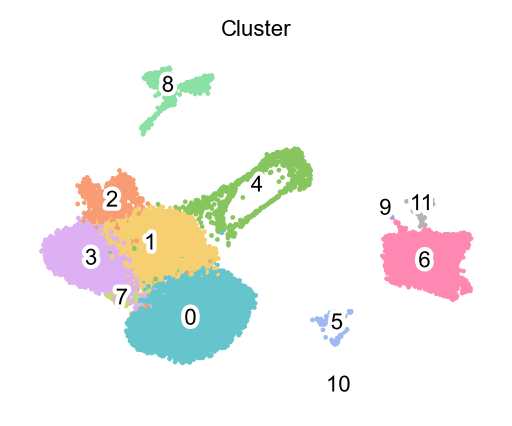

In [33]:
margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v1,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    legend_fontsize="medium",
    legend_fontweight="normal",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

#### LC

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'cell_type' as categorical


19.18649270913277


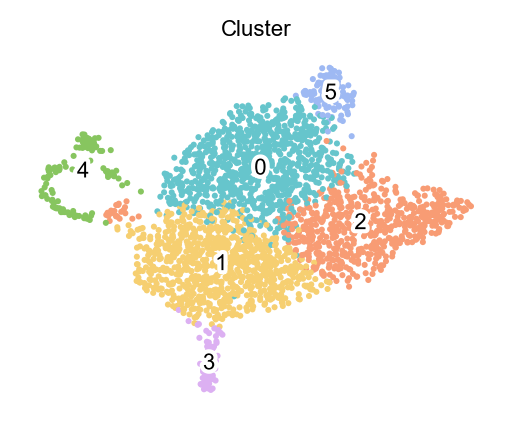

In [34]:
umap_dot_size_lc = 50000 / adata_lc.n_obs
print(umap_dot_size_lc)

margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_lc,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    legend_fontsize="medium",
    legend_fontweight="normal",
    size=umap_dot_size_lc,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

### Cell type

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


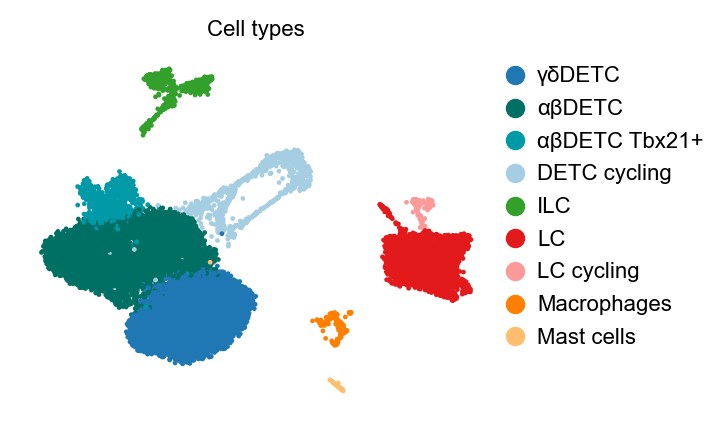

In [35]:
margin_right = (
    27.4 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v1,
    basis="X_umap",
    color="cell_type",
    palette=cell_type_colors,
    ax=axes,
    title="Cell types",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1 - (margin_right / fig_width), 0.5),
)

### Genotype

#### All cells

In [36]:
adata_cleaned_v1.obs["genotype"] = adata_cleaned_v1.obs["genotype"].astype(str).str.upper().astype('category').cat.reorder_categories(["WT", "KO"])

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


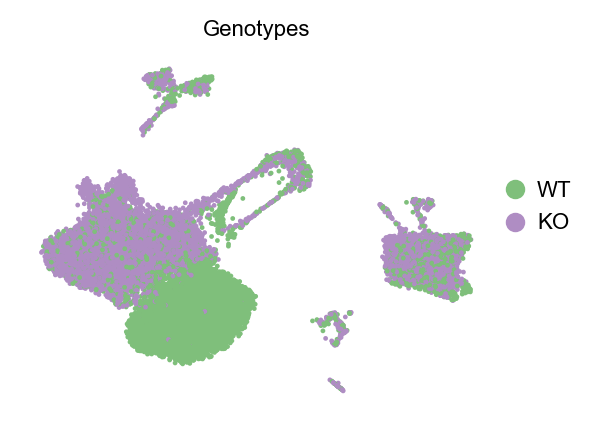

In [37]:
margin_right = (
    10.7 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v1,
    basis="X_umap",
    color="genotype",
    palette=genotype_colors,
    ax=axes,
    title="Genotypes",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1 - (margin_right / fig_width), 0.5),
)

#### LC

In [38]:
adata_lc.obs["genotype"] = adata_lc.obs["genotype"].astype(str).str.upper().astype('category').cat.reorder_categories(["WT", "KO"])

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'cell_type' as categorical


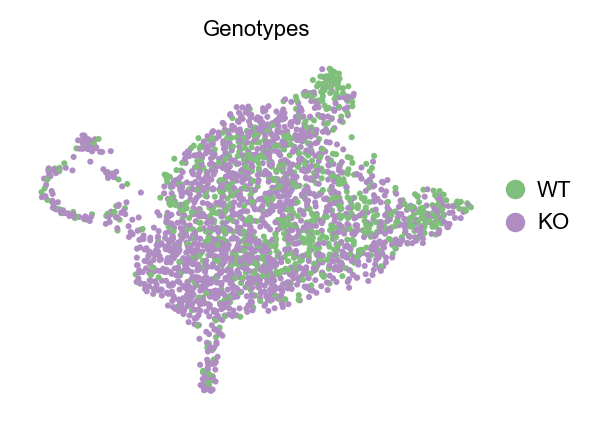

In [39]:
margin_right = (
    10.7 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_lc,
    basis="X_umap",
    color="genotype",
    palette=genotype_colors,
    ax=axes,
    title="Genotypes",
    size=umap_dot_size_lc,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1 - (margin_right / fig_width), 0.5),
)

## Barplot

### All cells

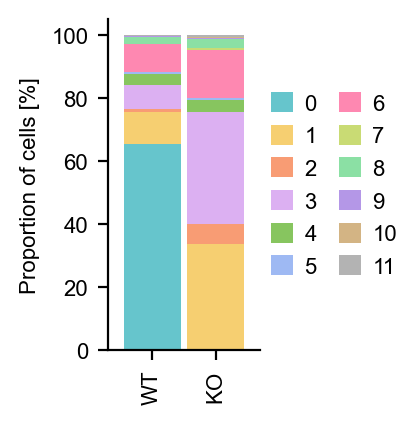

In [40]:
df = get_dataframe_barplot(
    adata_cleaned_v1, groupby="genotype", color_var="leiden", normalize_color_var=False
)

fig, axes = plt.subplots(figsize=(50/25.4, 51/25.4), dpi=200, layout="constrained")

p1 = df.plot(kind="bar", stacked=True, width=0.9, color=leiden_colors, ax=axes)

p1.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, ncol=2)

p1.set_xlabel("")
p1.set_ylabel("Proportion of cells [%]")

p1.spines["right"].set_visible(False)
p1.spines["top"].set_visible(False)

### LC

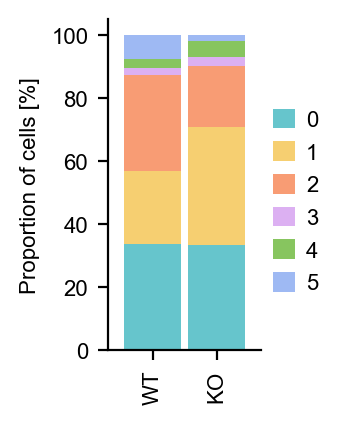

In [41]:
df = get_dataframe_barplot(
    adata_lc, groupby="genotype", color_var="leiden", normalize_color_var=False
)

fig, axes = plt.subplots(figsize=(40/25.4, 51/25.4), dpi=200, layout="constrained")

p1 = df.plot(kind="bar", stacked=True, width=0.9, color=leiden_colors, ax=axes)

p1.legend(loc="center left", bbox_to_anchor=(1, 0.45), frameon=False, ncol=1)

p1.set_xlabel("")
p1.set_ylabel("Proportion of cells [%]")

p1.spines["right"].set_visible(False)
p1.spines["top"].set_visible(False)

## Vulcanoplot

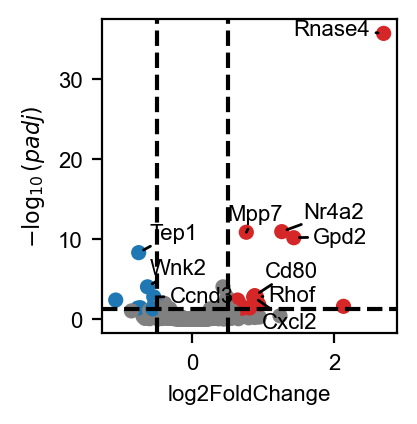

In [42]:
fig, axes = plt.subplots(figsize=(50/25.4, 51/25.4), dpi=200, layout="constrained")

dc.pl.volcano(results_deseq2, x="log2FoldChange", y="padj", top=10, ax=axes, thr_stat=0.5)

## Boxplot

In [ ]:
df = sc.get.obs_df(adata_lc, keys=["genotype", "batch_replicate"]).merge(
    adata_lc.obsm["score_aucell"], left_index=True, right_index=True
)

df = df.groupby(["genotype", "batch_replicate"], observed=True).mean().reset_index()

df['genotype'] = df['genotype'].str.upper().astype('category').cat.reorder_categories(['WT', 'KO'])

In [ ]:
_, p_val_mature = stats.mannwhitneyu(
    df[df["genotype"] == "KO"]["mature"],
    df[df["genotype"] == "WT"]["mature"],
    method='exact'
)

_, p_val_immature = stats.mannwhitneyu(
    df[df["genotype"] == "KO"]["immature"],
    df[df["genotype"] == "WT"]["immature"],
    method='exact'
)

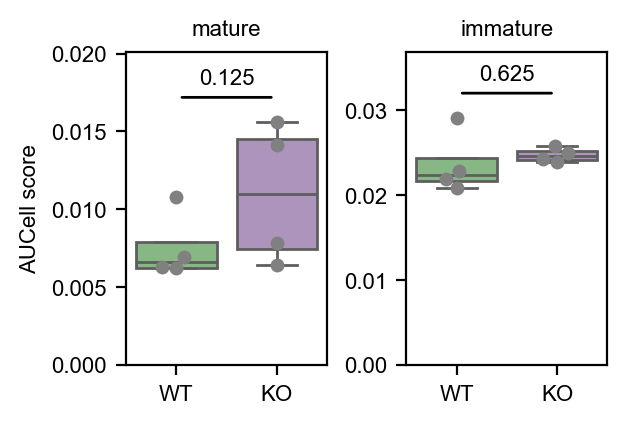

In [ ]:
gene_sets_subset = [
    "mature",
    "immature",
]

n_col = min(len(gene_sets_subset), 4)
n_row = int(np.ceil(len(gene_sets_subset) / n_col))

fig = plt.figure(figsize=(76.708/25.4, 51/25.4), dpi=200, layout="constrained")

for gene in gene_sets_subset:
    ax = fig.add_subplot(n_row, n_col, gene_sets_subset.index(gene) + 1)

    sns.boxplot(
        data=df, x="genotype", y=gene, hue="genotype", palette=genotype_colors, fliersize=0
    )

    sns.swarmplot(
        data=df,
        x="genotype",
        y=gene,
        color='#808080',
        legend=False
    )

    ax.set_title(f'{gene.split("_")[0]}',)

    if gene == "mature":
        ax.set_ylabel("AUCell score")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax*1.25)

    x_start, x_end = ax.get_xticks()
    biggest_y = df[gene].max()*1.1
    
    ax.annotate(
        text='',
        xy=(x_start, biggest_y),
        xytext=(x_end, biggest_y),
        arrowprops=dict(arrowstyle='-', color='black', lw=1),
    )

    ax.text(
        x=(x_end + x_start) / 2,
        y=biggest_y*1.05,
        s=round(p_val_mature if gene == "mature" else p_val_immature, 2),
        ha='center',
    )